In [1]:
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp

2023-02-28 20:38:02.981970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-02-28 20:38:06.878131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-02-28 20:38:06.879143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-02-28 20:38:06.879156: W t

In [2]:
def parametric_fn(t0, t_rise, t_fall, amplitude, x_range):
    
    time_dif = x_range - t0
    numerator = jnp.exp(-time_dif/t_fall)
    denominator = 1 + jnp.exp(-time_dif/t_rise)
    predicted_lc = amplitude * ( numerator/ denominator )
    return predicted_lc

In [3]:
tfd = tfp.distributions
rng = jax.random.PRNGKey(0)

def jd_model(x_range):

    @tfd.JointDistributionCoroutineAutoBatched
    def current_event():

        t0 = yield tfd.Gamma(1, 1, name='t0')
        t_rise = yield tfd.Gamma(1, 1, name='t_rise')
        t_fall = yield tfd.Gamma(1, 1, name='t_fall')
        amplitude = yield tfd.Gamma(1, 1, name='amp')

        prediction = parametric_fn(t0, t_rise, t_fall, amplitude, x_range)

        # Likelihood
        sigma = yield tfd.Sample(tfd.Gamma(1, 1), 1, name='sigma') 
        yield tfd.Normal(prediction, sigma, name='obs')

    return current_event

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


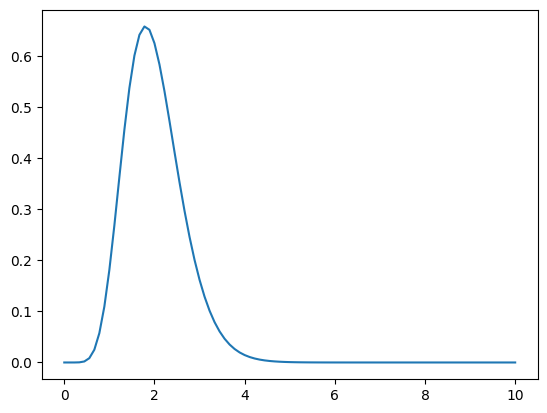

In [36]:
import numpy as np
import matplotlib.pyplot as plt

x_ = np.linspace(-1, 10, 100)
prob = tfd.Gamma(10, 5).prob(x_)
plt.plot(x_, prob)

In [ ]:
prob = tfd.Uniform(0, 1).prob(x_)

In [ ]:
x_range = jnp.asarray([-2, 0, 4])
sigma = jnp.asarray([3, 5, 4], dtype=jnp.float32)
obs = jnp.asarray([100, 200, 150], dtype=jnp.float32)

model = jd_model(jnp.array(x_range))
_ = model.sample(seed=rng)
model.sample(5, seed=rng)

In [ ]:
pinned_jd = model.experimental_pin(sigma=jnp.array(sigma), obs=jnp.array(obs))

In [ ]:
pinned_jd = model.experimental_pin(sigma=sigma, obs=obs)
val, logp = pinned_jd.sample_and_log_weight(5, seed=rng)
pinned_jd.unnormalized_log_prob_parts(val)

# Multi event multi channel

In [ ]:
# likelihood = tfd.Normal(0, 1).log_prob(obs)

# likelihood_fn = lambda mu, sigma, y: tfd.Normal(mu, sigma).log_prob(y)

# lp = likelihood_fn(0, 1, np.linspace(-100, 100, 500))
# plt.plot(np.linspace(-100, 100, 500), lp)

In [ ]:
# y = 1.
# lp = likelihood_fn(np.linspace(-100, 100, 500), 1, y)

### Define the joind distribution 
Note that currently there are no interband correlation incorporated in the priors

In [ ]:
# hyper_prior  # shape = ()
# hyper_prior_bands(hyper_prior)  # shape = (3, )
# prior_bands_and_events  # shape = (3, num_events)

# hyper_prior_events  # shape=(1, num_events)
# prior_bands_and_events = hyper_prior_bands * hyper_prior_events  
# prior_bands_and_events  # shape = (3, num_events)

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def prior():
    hyper_prior = yield tfd.Normal(0., 10)
    prior = yield tfd.Sample(tfd.Normal(hyper_prior, 1), 3)
    prior_bands_and_events = yield tfd.Sample(tfd.Normal(prior, .5), num_events)

In [5]:
# Disdistribution with interband correlations
# TODO: find the actual correlation between the bands.

def jd_model(index, x_range):

    assert index.shape[0] == x_range.shape[0]

    num_channel = np.unique(index[:, 0]).shape[0]
    num_event = np.unique(index[:, 1]).shape[0]

    @tfd.JointDistributionCoroutineAutoBatched
    def current_event():
        # define priors
        t0 = yield tfd.Sample(tfd.Normal(0, .25), (num_channel, num_event), name="t0")

        t_rise_hyper_prior = yield tfd.Sample(tfd.Uniform(.25, 5), (num_event), name="t_rise_hyper")
        t_rise = yield tfd.Sample(tfd.Uniform(t_rise_hyper_prior/2, t_rise_hyper_prior + t_rise_hyper_prior/2), (num_channel), name="t_rise")

        t_fall_hyper_prior = yield tfd.Sample(tfd.Uniform(.25, 10), (num_event), name="t_fall_hyper_prior")
        t_fall_= yield tfd.Sample(tfd.Uniform(t_fall_hyper_prior/2, t_fall_hyper_prior + t_fall_hyper_prior/2), (num_channel), name="t_fall_")
        
        t_fall = t_rise + t_fall_

        amplitude = yield tfd.Sample(tfd.Gamma(2, .5), (num_channel, num_event), name="amp")
    
        # evaluate the oredictions
        #note index changes because of hyperpriors
        prediction = parametric_fn(
            t0[index[:, 0], index[:, 1]],
            t_rise[index[:, 1], index[:, 0]],
            t_fall[index[:, 1], index[:, 0]],
            amplitude[index[:, 0], index[:, 1]], 
            x_range,
        )

        # Likelihood
        sigma = yield tfd.Sample(tfd.Gamma(1, 1), 1, name="sigma")
        yield tfd.Normal(prediction, sigma, name="obs")

    return current_event

In [6]:
# create toy example

index = np.asarray([
    [0, 0],
    [0, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [0, 1],
    [0, 1],
    [0, 1],
    [0, 1],
    [1, 1],
    [1, 1],
    [1, 1],
    [1, 1],
])

x_range = np.asarray([-2, 0, -2, 0, 2, 4, -2, 0, 2, 4, -2, 0, 2, 4])

observed_sigma = jnp.array(np.asarray([10, 40, 10, 40, 30, 25,10, 40, 30, 25,10, 40, 30, 25])/2000, dtype=jnp.float32)
observed_value = jnp.array(np.asarray([200, 2000, 200, 2000, 1500, 500, 400, 2000, 1000, 400, 100, 2000, 500, 200])/2000, dtype=jnp.float32)

jd = jd_model(index, x_range)

In [7]:
jd.sample(seed=rng)

StructTuple(
  t0=Array([[-0.34559786, -0.35756034],
           [-0.01132559,  0.36089513]], dtype=float32),
  t_rise_hyper=Array([2.9231048, 1.2182004], dtype=float32),
  t_rise=Array([[2.918316 , 3.851437 ],
           [0.6242849, 1.5033934]], dtype=float32),
  t_fall_hyper_prior=Array([3.1811237, 9.85458  ], dtype=float32),
  t_fall_=Array([[ 4.194861 ,  3.937777 ],
           [10.870595 ,  7.6942573]], dtype=float32),
  amp=Array([[7.961033 , 7.0254993],
           [3.5211155, 4.358237 ]], dtype=float32),
  sigma=Array([1.0040799], dtype=float32),
  obs=Array([ 4.050764  ,  3.149367  , -0.4338447 , -0.16156828,  1.9421455 ,
            0.4561622 ,  0.9968735 ,  4.793054  ,  6.1170206 ,  4.887946  ,
           -1.6906066 ,  2.3691437 ,  2.6399376 ,  5.0137634 ], dtype=float32)
)

In [8]:
# pinned_jd = jd.experimental_pin(
#         sigma=observed_sigma, 
#         obs=observed_value,
# )

# run_mcmc = jax.jit(
#     lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
#         1000, 
#         pinned_jd, 
#         n_chains=4, 
#         num_adaptation_steps=1000, 
#         seed=seed,
#     )
# )

# rng, sample_rng = jax.random.split(rng, 2)
# mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [9]:
run_mcmc = jax.jit(
    lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )
)

rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [10]:
# pinned_jd = jd.experimental_pin(
#         sigma=observed_sigma, 
#         obs=observed_value,
# )

# rng, sample_rng = jax.random.split(rng, 2)
# result = pinned_jd.sample_and_log_weight(seed=sample_rng)

In [11]:

# def gen_pred(index, x_range, param):
    
#     return parametric_fn(
#             param.t0[index[:, 0], index[:, 1]],
#             param.t_rise[index[:, 0], index[:, 1]],
#             param.t_fall[index[:, 0], index[:, 1]],
#             param.amp[index[:, 0], index[:, 1]], 
#             x_range,
#         )

# gen_pred(index, x_range, result[0])

### plot posterior for event 0, band 0

Text(0, 0.5, 'Aribitrary units')

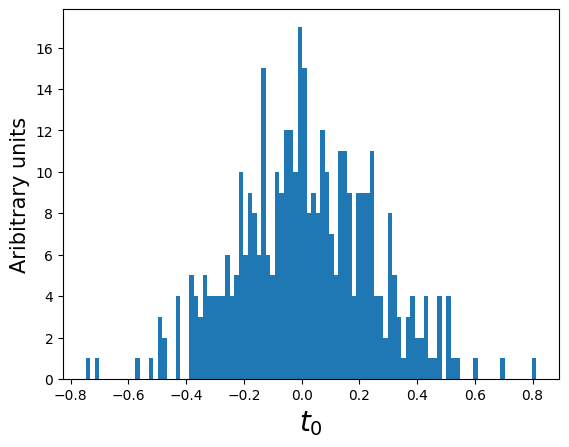

In [12]:
plt.hist(np.ravel(mcmc_samples.t0[..., 0, 0]), 100);
plt.xlabel("$t_{0}$", fontsize=20)
plt.ylabel("Aribitrary units", fontsize=15)

Text(0, 0.5, 'Aribitrary units')

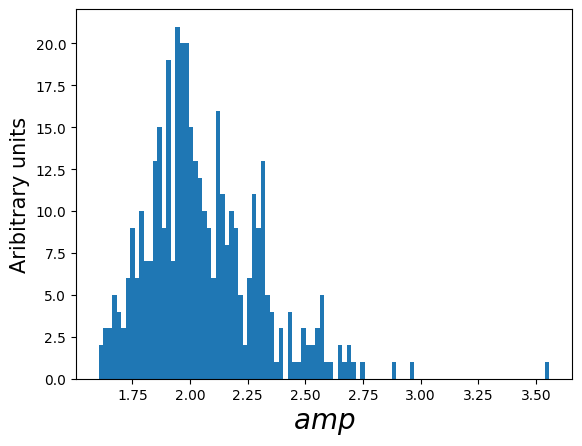

In [13]:
plt.hist(np.ravel(mcmc_samples.amp[..., 0, 0]), 100);
plt.xlabel("$amp$", fontsize=20)
plt.ylabel("Aribitrary units", fontsize=15)

Text(0, 0.5, 'Aribitrary units')

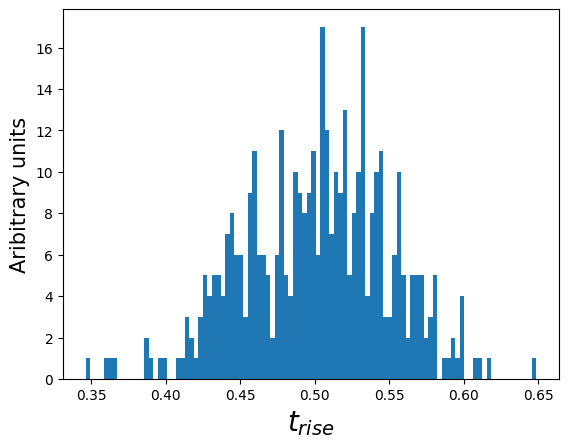

In [14]:
plt.hist(np.ravel(mcmc_samples.t_rise[..., 0, 0]), 100);
plt.xlabel("$t_{rise}$", fontsize=20)
plt.ylabel("Aribitrary units", fontsize=15)

Text(0, 0.5, 'Aribitrary units')

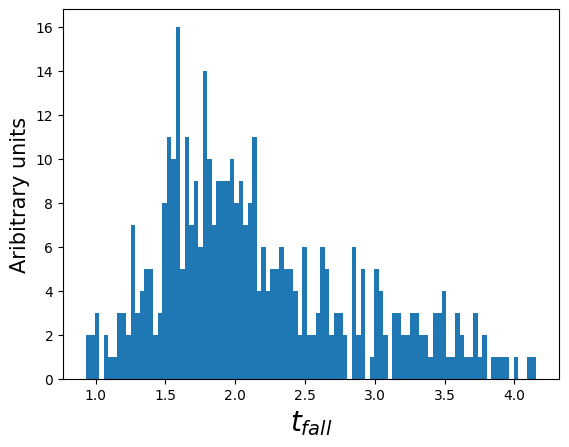

In [15]:
plt.hist(np.ravel(mcmc_samples.t_fall_[..., 0, 0] + mcmc_samples.t_rise[..., 0, 0]), 100);
plt.xlabel("$t_{fall}$", fontsize=20)
plt.ylabel("Aribitrary units", fontsize=15)

In [16]:
np.shape(mcmc_samples.t0)

(100, 4, 2, 2)

### Plot the posterior of the predicted lightcurve

In [17]:
t0 = np.mean(mcmc_samples.t0[..., 0, 0])
t_rise = np.mean(mcmc_samples.t_rise[..., 0, 0])
t_fall_ = np.mean(mcmc_samples.t_fall_[..., 0, 0])
t_fall = t_fall_ + t_rise
amp = np.mean(mcmc_samples.amp[..., 0, 0])

In [18]:
predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))

<ErrorbarContainer object of 3 artists>

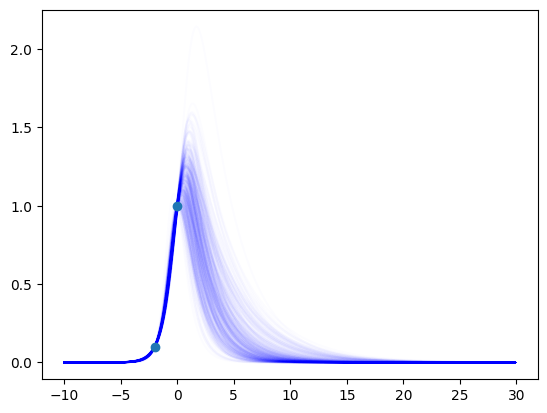

In [19]:
#plt.plot(np.arange(-10,30, .1), predictions)
for i in range(100):
    for j in range(4):
        t0 = mcmc_samples.t0[i, j, 0, 0]
        t_rise = mcmc_samples.t_rise[i, j, 0, 0]
        t_fall_ = mcmc_samples.t_fall_[i, j, 0, 0]
        t_fall = t_fall_ + t_rise
        amp = mcmc_samples.amp[i, j, 0, 0]
        predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
        plt.plot(np.arange(-10,30, .1), predictions, alpha=.01, color='blue')
plt.errorbar([-2, 0], np.array([200, 2000])/2000, yerr=np.array([10, 40])/2000, fmt="o")

<ErrorbarContainer object of 3 artists>

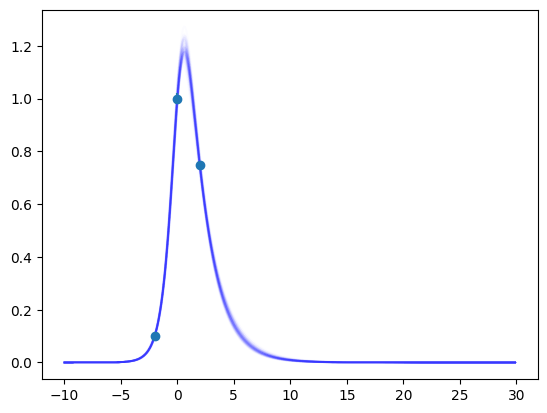

In [20]:
#plt.plot(np.arange(-10,30, .1), predictions)
for i in range(100):
    for j in range(4):
        t0 = mcmc_samples.t0[i, j, 1, 0]
        t_rise = mcmc_samples.t_rise[i, j, 0, 1]
        t_fall_ = mcmc_samples.t_fall_[i, j, 0, 1]
        t_fall = t_fall_ + t_rise
        amp = mcmc_samples.amp[i, j, 1, 0]
    predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
    plt.plot(np.arange(-10,30, .1), predictions, alpha=.01, color='blue')
plt.errorbar([-2, 0, 2], np.array([200, 2000, 1500])/2000, yerr=np.array([10, 40, 30])/2000, fmt="o")

In [ ]:
import astropy
from astropy.table import Table

In [ ]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'

In [ ]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [ ]:
df_phot

In [ ]:
object_index = []
last_object = 0
count = 0
for i in range(len(df_phot)):

    if i == 0:
        last_object = df_phot['SNID'].iloc[0]

    if df_phot['SNID'].iloc[i] == last_object:
        object_index.append(count)
    else:
        last_object = df_phot['SNID'].iloc[i]
        count = count+1
        object_index.append(count)

In [ ]:
len(np.unique(df_phot['SNID']))

In [ ]:
band_index = (df_phot['FLT'] == b'g').values*1

In [ ]:
len(band_index)

In [ ]:
len(object_index)

In [ ]:
index = np.zeros((len(object_index),2), dtype=np.int32)

In [ ]:
index[:, 0] = object_index

In [ ]:
index[:, 1] = band_index

In [ ]:
index

In [ ]:
df_phot["object_index"] = object_index
df_phot["band_index"] = band_index

In [ ]:
df_phot

In [ ]:
df_header

In [ ]:
import pandas as pd

new_object_dfs = []

count = 0
for object_id in df_header['SNID']:

    object_df = df_phot[df_phot["SNID"] == object_id]
    r_band_data = object_df[object_df['FLT'] == b'r']
    
    max_flux_loc = np.argmax(r_band_data["FLUXCAL"])
    max_flux = r_band_data['FLUXCAL'].iloc[max_flux_loc]
    max_flux_time = r_band_data['MJD'].iloc[max_flux_loc]
    
    new_time = object_df['MJD'] - max_flux_time
    new_flux = object_df['FLUXCAL'] / max_flux
    new_flux_err = object_df['FLUXCALERR'] / max_flux
        
    current_object_new_df = {}
    current_object_new_df['SNID'] = object_df['SNID']
    current_object_new_df['time'] = new_time
    current_object_new_df['flux'] = new_flux
    current_object_new_df['fluxerr'] = new_flux_err
    current_object_new_df['object_index'] = object_df['object_index']
    current_object_new_df['band_index'] = object_df['band_index']
    current_object_new_df['norm_factor'] = max_flux
    
    current_object_new_df = pd.DataFrame.from_dict(current_object_new_df)

    new_object_dfs.append(current_object_new_df)
    count+=1
    
    if count ==1000:
        break

    
new_object_dfs = pd.concat(new_object_dfs, axis=0, ignore_index=True)

In [ ]:
new_object_dfs

In [ ]:
new_object_dfs.to_csv("mcmc_dataset.csv")

In [ ]:
index = np.zeros((len(new_object_dfs), 2), dtype=np.int32)

index[:, 0] = new_object_dfs["object_index"]
index[:, 1] = new_object_dfs["band_index"]

x_range = np.asarray(new_object_dfs["time"])

observed_sigma = jnp.array(np.asarray(new_object_dfs["flux"]), dtype=jnp.float32)
observed_value = jnp.array(np.asarray(new_object_dfs["fluxerr"]), dtype=jnp.float32)

jd = jd_model(index, x_range)

run_mcmc = jax.jit(
    lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )
)

rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)